In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot
import legacy.eigenstate_generator as eig_old

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median, mean
from matplotlib.ticker import FormatStrFormatter

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

small_ham_keys = []

for h in hamiltonians.keys():
    num_qubits = hamiltonians[h][1]
    if num_qubits < 10:
        small_ham_keys.append(h)

print(len(small_ham_keys))
small_ham_keys

12


['Be1_STO-3G_singlet',
 'H1-F1_STO-3G_singlet',
 'H1-Li1_STO-3G_singlet',
 'H1-O1_STO-3G_singlet',
 'H2-Be1_STO-3G_singlet',
 'H2_3-21G_singlet',
 'H2_6-31G_singlet',
 'Ne1_STO-3G_singlet',
 'H1-He1_STO-3G_singlet',
 'H3_STO-3G_singlet_1+',
 'H1-He1_3-21G_singlet_1+',
 'H3_3-21G_singlet_1+']

In [3]:
shots=5
nc_mols={}

for speciesname in small_ham_keys:
    print(speciesname)
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)
    initial_state = mol.init_state()
    G = mol.generators()[0]
    A = mol.generators()[1]
    eig_proj = la.eigenstate_projector(A, num_qubits)
    results = {}
    nan_check = []
    for index in range(num_qubits):
        removed_index = list(range(0, index))
        removed_index.reverse()
        removed_generators = [list(G.keys())[i] for i in removed_index]
        Z_indices = [g.find('Z') for g in removed_generators]
        nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

        new_ham_noncon, new_ham_context = mol.move_generator(removed_generators)
        new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
        new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)
        
        results[index] = {}

        results[index]['exact'] = get_ground_state(get_sparse_operator(new_ham_noncon_q, num_qubits).toarray())[0]

        expectations = []
        for r in range(shots):
            #expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
            #                                                          r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
            #                                                          Z_indices=Z_indices,rot=True)
            rand_vec = la.random_complex_vector(2**num_qubits)
            psi = la.apply_projections(rand_vec, [nc_proj, eig_proj])
            expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
            #print(expect_noncon)
            expectations.append(expect_noncon)
        
        nc_value = (sum(expectations)/shots).real
        results[index]['+1eig'] = nc_value
        nan_check.append(nc_value)
    
    if all([not np.isnan(n) for n in nan_check]):
        nc_mols[speciesname] = results
        nc_mols[speciesname]['num_qubits'] = num_qubits

nc_mols

Be1_STO-3G_singlet


/mnt/c/Users/Tim/Jupyter Projects/ContextualSubspaceVQE/utils/linalg_tools.py:101: RuntimeWarning: invalid value encountered in true_divide
  psi = psi/norm


H1-F1_STO-3G_singlet
H1-Li1_STO-3G_singlet
H1-O1_STO-3G_singlet
H2-Be1_STO-3G_singlet
H2_3-21G_singlet
H2_6-31G_singlet
Ne1_STO-3G_singlet
H1-He1_STO-3G_singlet
H3_STO-3G_singlet_1+
H1-He1_3-21G_singlet_1+
H3_3-21G_singlet_1+


{'H1-F1_STO-3G_singlet': {0: {'exact': -103.55745152883404,
   '+1eig': -103.55745152883406},
  1: {'exact': -102.91839475990946, '+1eig': -102.91839475990938},
  2: {'exact': -101.12609567566611, '+1eig': -101.09343070449401},
  3: {'exact': -100.54798077789373, '+1eig': -100.54758926681978},
  4: {'exact': -99.15696348335247, '+1eig': -99.15695679751286},
  5: {'exact': -97.59113177327427, '+1eig': -97.59112609137381},
  6: {'exact': -82.99500557442894, '+1eig': -82.99500081802275},
  7: {'exact': -67.06392006629686, '+1eig': -67.06391598949283},
  'num_qubits': 8},
 'H1-Li1_STO-3G_singlet': {0: {'exact': -8.914131227844866,
   '+1eig': -8.914131227844834},
  1: {'exact': -8.128501681195658, '+1eig': -8.128328357686812},
  2: {'exact': -7.540564320035246, '+1eig': -7.540506106944901},
  3: {'exact': -7.3713104204488955, '+1eig': -7.124196839352402},
  4: {'exact': -7.089273642953567, '+1eig': -6.731134449484258},
  5: {'exact': -6.910522743104613, '+1eig': -6.908498393424314},
  6: {

In [4]:
nc_mols.pop('Ne1_STO-3G_singlet')

{0: {'exact': -126.60452499680473, '+1eig': -126.60452499680478},
 1: {'exact': -121.44961238741679, '+1eig': -121.44951927689615},
 2: {'exact': -119.36847036412922, '+1eig': -119.36838329057787},
 3: {'exact': -115.39499315281549, '+1eig': -115.39483537468844},
 4: {'exact': -96.73937499352387, '+1eig': -96.7388672770862},
 'num_qubits': 5}

(2, 5)


Text(0.5, 0.98, 'Noncontextual ground state energy - restriction to +1-eigenspace versus exact')

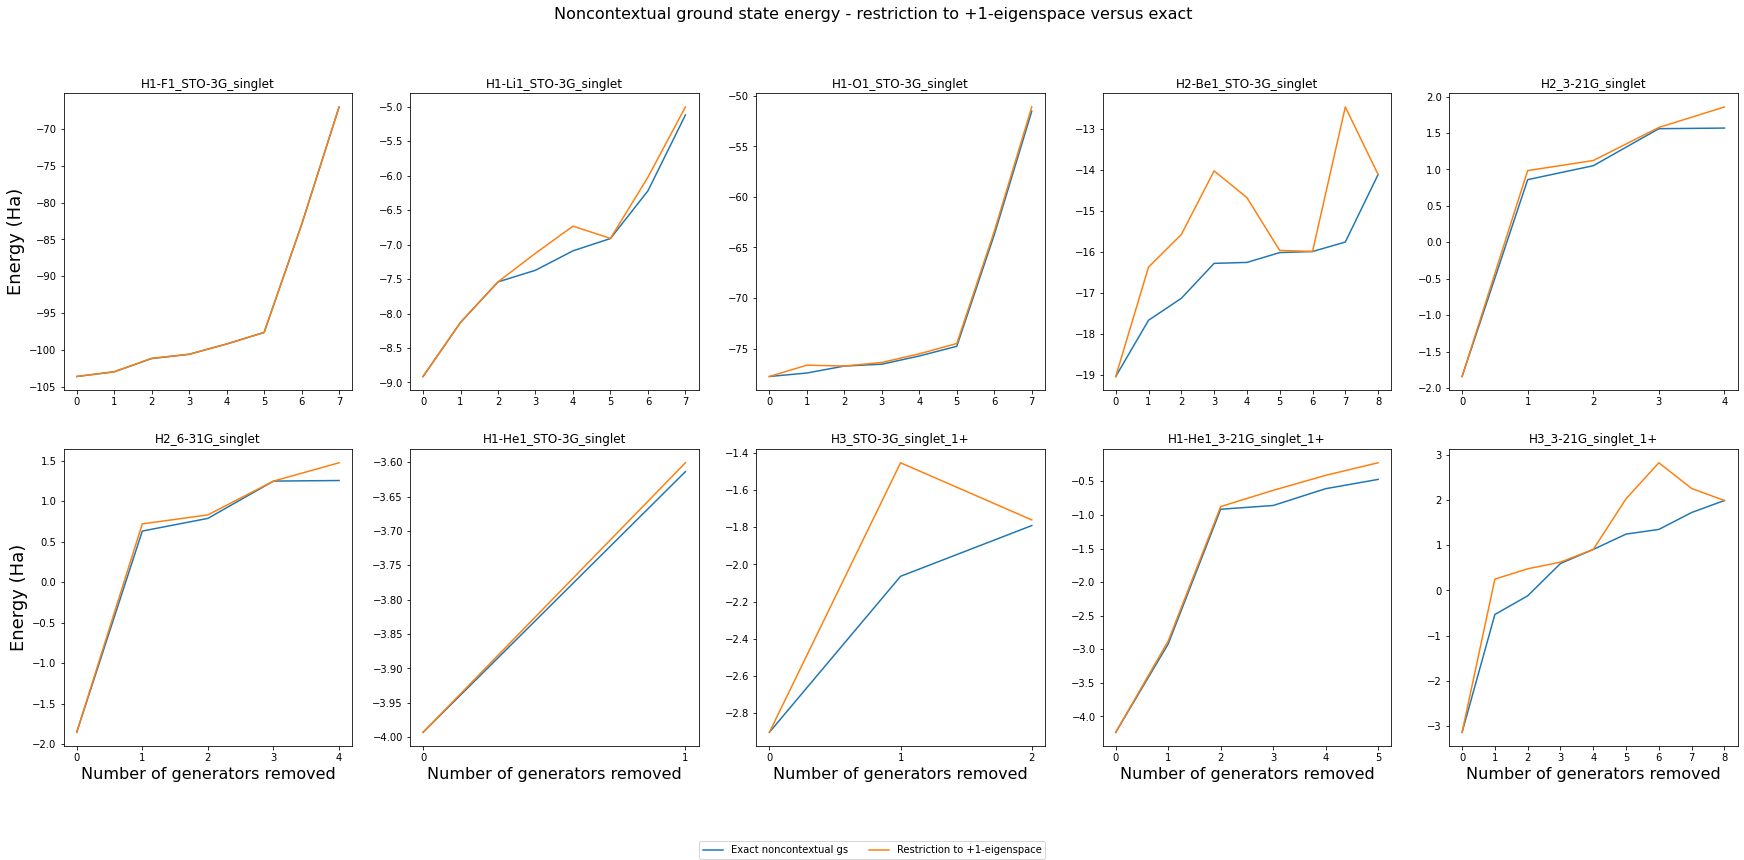

In [5]:
factors = la.factor_int(len(nc_mols))
print(factors)
if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))

for index, h in enumerate(nc_mols.keys()):
    grid = grid_pos[index]
    
    num_qubits = nc_mols[h]['num_qubits']
    X=range(num_qubits)
    values = list(zip(*[list(nc_mols[h][i].values()) for i in X]))
    Y1=values[0]
    Y2=values[1]
    axs[grid].set_title(str(h))
    l1 = axs[grid].plot(X, Y1, label='Exact noncontextual gs')
    l2 = axs[grid].plot(X, Y2, label='Restriction to +1-eigenspace')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 1:
            axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2) 
fig.suptitle('Noncontextual ground state energy - restriction to +1-eigenspace versus exact', fontsize=16)

In [6]:
#fig.savefig("plots/nc_+1_restriction_versus_exact", dpi=300)

In [7]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, list(range(num_qubits)))
    A = mol.A
    print(A)
    
    qubit_nums = range(1, num_qubits+1)
    gs_true = []
    gs_proj = []

    for n_q in qubit_nums:
        ham_red = mol.ham_reduced[n_q-1]
        ham_red_q = qonvert.dict_to_QubitOperator(ham_red)
        gs_red = get_ground_state(get_sparse_operator(ham_red_q, n_q).toarray())
        gs_true.append(gs_red[0])

        A_red = mol.reduce_anz_terms(A, n_q)
        eig_proj = la.eigenstate_projector(A_red, n_q)
        psi = gs_red[1]
        psi_proj = la.apply_projections(psi, [eig_proj])
        expct_proj = la.expectation(ham_red, psi_proj, n_q)
        gs_proj.append(expct_proj)
    
    proj_energy[speciesname] = {'qubit_nums':qubit_nums,
                               'gs_true':gs_true,
                               'gs_proj':gs_proj}

{'IIIXI': -6.029070514886671e-09, 'IIIZI': -1.0}


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


{'IIXZZZZZ': 2.0113630944690537e-07, 'IIZIIIII': -0.9999999999999798}
{'IIIIIXZZ': -1.0575336511480974e-07, 'ZZIZIZIZ': 0.9999999999999944}
{'IIXZZZZZ': 0.7907783549812867, 'IIZIIIII': -0.6121026002992391}
{'IIIIIIZIX': 1.7227299204006994e-08, 'IIIIIIIIZ': -0.9999999999999999}
{'IZIXZ': -1.7229076004935604e-08, 'ZZZZZ': -0.9999999999999999}
{'IZIXZ': -1.7235760657766872e-08, 'ZZZZZ': -0.9999999999999999}
{'IIIXZ': 9.695054298836442e-08, 'IIIZI': -0.9999999999999953}
{'XZ': 1.7385187128963406e-08, 'ZI': -0.9999999999999999}
{'ZZZ': 0.9799593338761482, 'ZZX': -0.19919765046058108}
{'IZIZIZ': -0.9999999999999987, 'IZZXZZ': 5.068707371578793e-08}
{'IIZZZIZZX': -6.084581987680557e-08, 'IIZIZZZZZ': -0.9999999999999981}


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, 'Contextual subspace ground state energy - projection into +1-eigenspace versus exact')

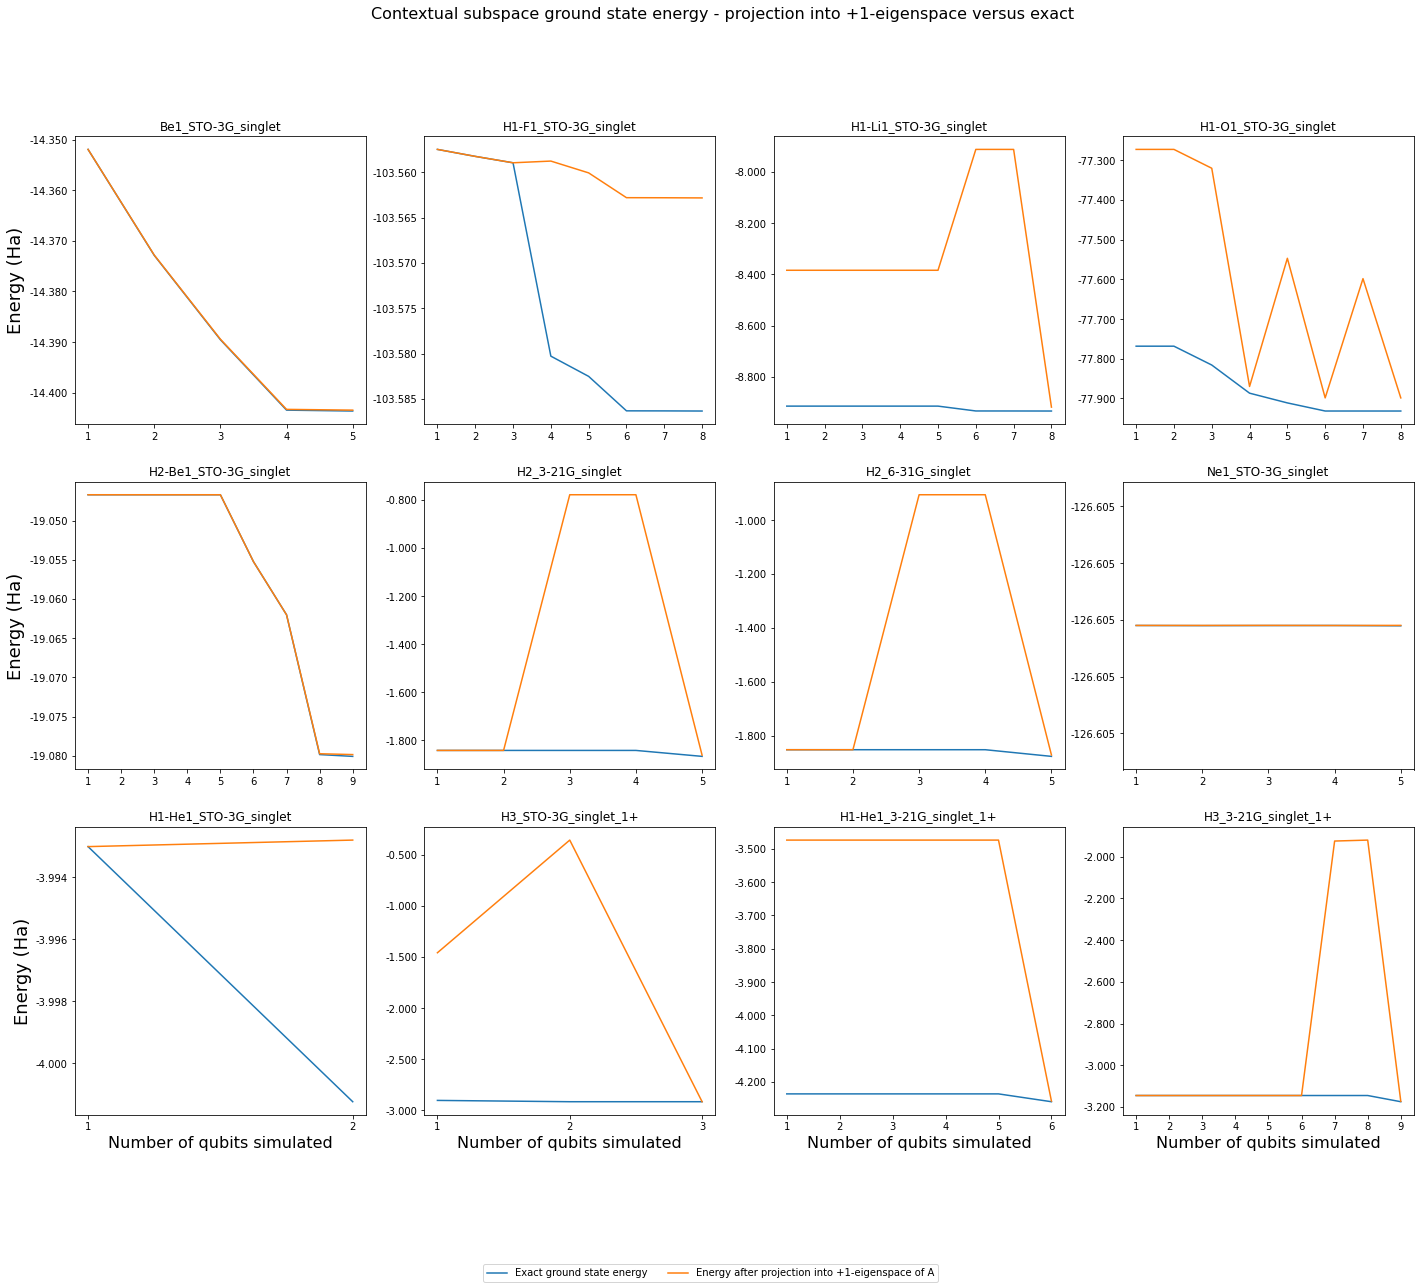

In [8]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    Y1 = mol_results['gs_true']
    Y2 = mol_results['gs_proj']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    l1 = axs[grid].plot(X, Y1, label='Exact ground state energy')
    l2 = axs[grid].plot(X, Y2, label='Energy after projection into +1-eigenspace of A')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2)

fig.suptitle('Contextual subspace ground state energy - projection into +1-eigenspace versus exact', fontsize=16)
    

In [9]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol_temp = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)
    A = mol_temp.generators()[1]
    for p in A.keys():
        if 'X' in list(p):
            X_index = p.index('X')
    order = [X_index] + [i for i in range(0, num_qubits) if i != X_index]
    mol = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, order)
    print(A)
    
    qubit_nums = range(1, num_qubits+1)
    gs_true = []
    gs_proj = []

    for n_q in qubit_nums:
        ham_red = mol.ham_reduced[n_q-1]
        ham_red_q = qonvert.dict_to_QubitOperator(ham_red)
        ham_mat = np.matrix(get_sparse_operator(ham_red_q, n_q).toarray())
        gs_true.append(get_ground_state(ham_mat)[0])
        
        A_red = mol.reduce_anz_terms(A, n_q)
        eig_mat = np.matrix(la.eigenstate_projector(A_red, n_q))
        ham_proj = eig_mat*ham_mat*eig_mat.H
        gs_proj.append(get_ground_state(ham_proj)[0])
        
    
    proj_energy[speciesname] = {'qubit_nums':list(qubit_nums),
                                'gs_true':gs_true,
                                'gs_proj':gs_proj,
                                'diff':[a-b for a, b in zip(gs_proj, gs_true)]}

{'IIIXI': -6.029070514886671e-09, 'IIIZI': -1.0}


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


{'IIXZZZZZ': 2.0113630944690537e-07, 'IIZIIIII': -0.9999999999999798}
{'IIIIIXZZ': -1.0575336511480974e-07, 'ZZIZIZIZ': 0.9999999999999944}
{'IIXZZZZZ': 0.7907783549812867, 'IIZIIIII': -0.6121026002992391}
{'IIIIIIZIX': 1.7227299204006994e-08, 'IIIIIIIIZ': -0.9999999999999999}
{'IZIXZ': -1.7229076004935604e-08, 'ZZZZZ': -0.9999999999999999}
{'IZIXZ': -1.7235760657766872e-08, 'ZZZZZ': -0.9999999999999999}
{'IIIXZ': 9.695054298836442e-08, 'IIIZI': -0.9999999999999953}
{'XZ': 1.7385187128963406e-08, 'ZI': -0.9999999999999999}
{'ZZZ': 0.9799593338761482, 'ZZX': -0.19919765046058108}
{'IZIZIZ': -0.9999999999999987, 'IZZXZZ': 5.068707371578793e-08}
{'IIZZZIZZX': -6.084581987680557e-08, 'IIZIZZZZZ': -0.9999999999999981}


In [10]:
proj_energy

{'Be1_STO-3G_singlet': {'qubit_nums': [1, 2, 3, 4, 5],
  'gs_true': [-14.351880476202043,
   -14.351880476202048,
   -14.37288791715924,
   -14.389646532766404,
   -14.403655108067754],
  'gs_proj': [-14.351880476202043,
   -14.351880476202046,
   -14.372837909454095,
   -14.389536593826197,
   -14.403479129166053],
  'diff': [0.0,
   1.7763568394002505e-15,
   5.000770514484998e-05,
   0.00010993894020749906,
   0.00017597890170151231]},
 'H1-F1_STO-3G_singlet': {'qubit_nums': [1, 2, 3, 4, 5, 6, 7, 8],
  'gs_true': [-103.55745152883412,
   -103.57929641696612,
   -103.57981333735482,
   -103.5802902464386,
   -103.5825248423843,
   -103.58633261280634,
   -103.58633866532581,
   -103.58635295327016],
  'gs_proj': [-103.55745152883412,
   -103.55745152883412,
   -103.55822240972783,
   -103.55893065505114,
   -103.56043882358523,
   -103.56310577851796,
   -103.56311421760786,
   -103.56313164494352],
  'diff': [0.0,
   0.021844888131994367,
   0.021590927626988332,
   0.02135959138745

Text(0.5, 0.98, 'Contextual subspace ground state energy - projection into +1-eigenspace versus exact')

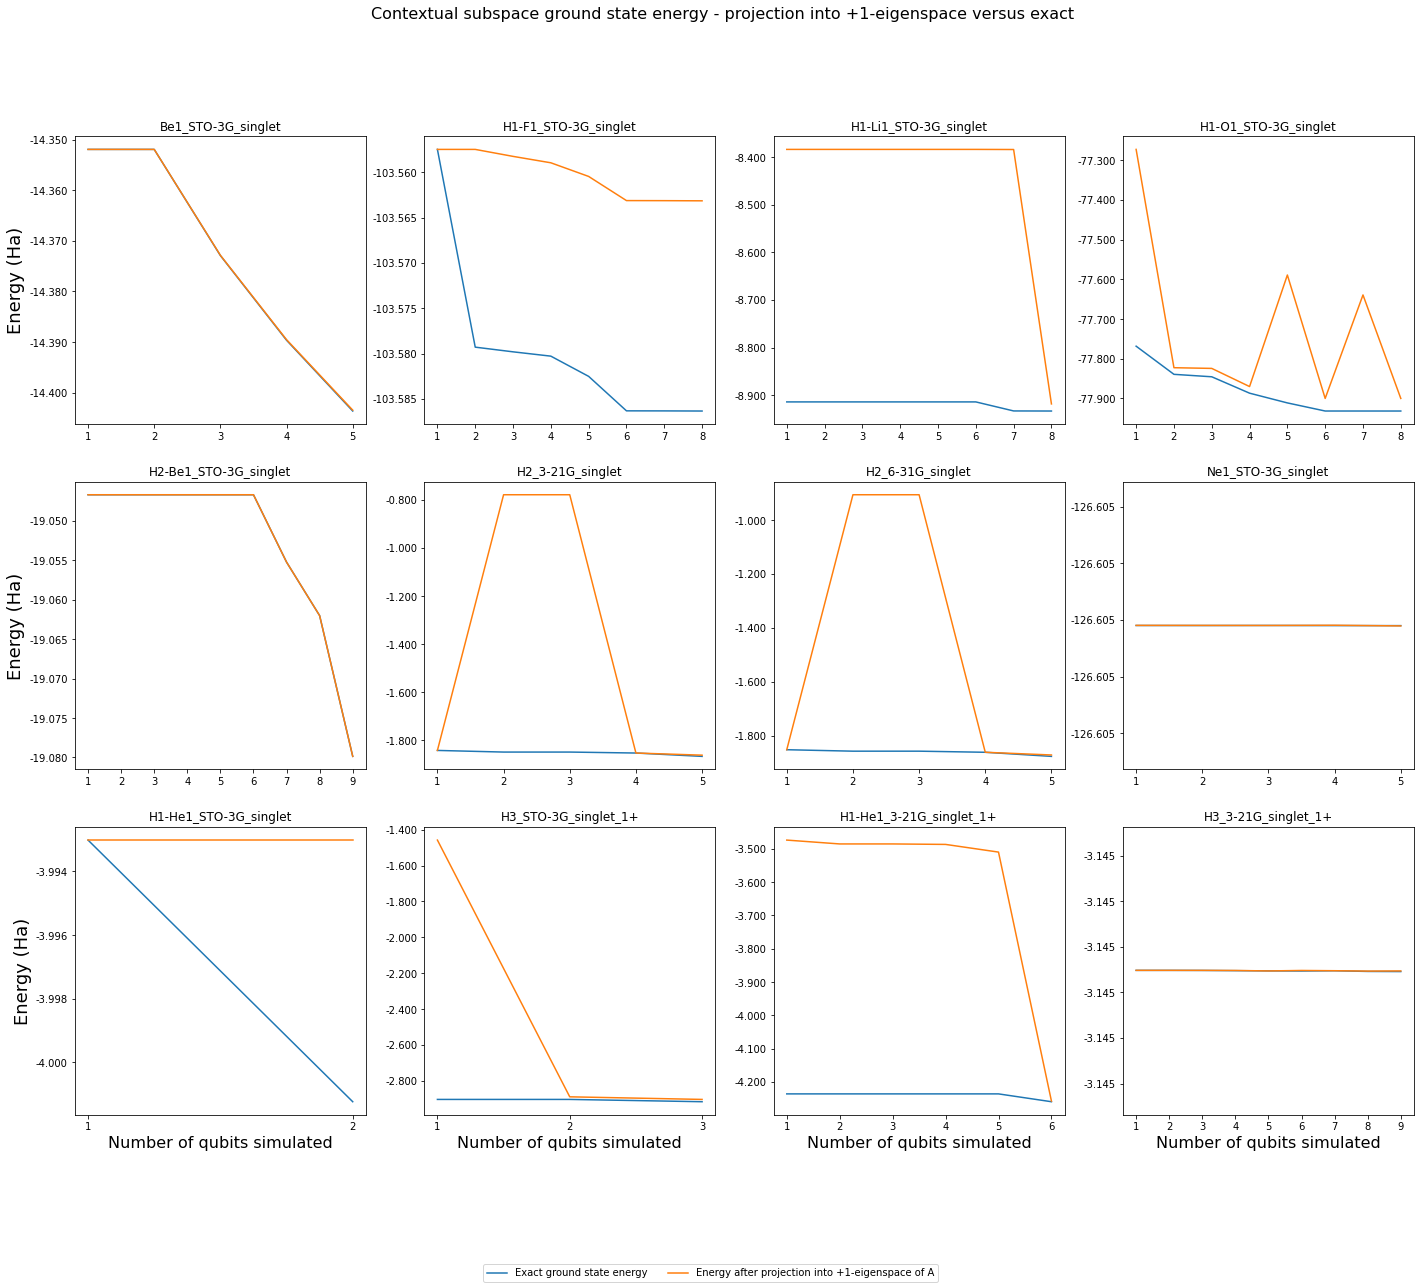

In [11]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    Y1 = mol_results['gs_true']
    Y2 = mol_results['gs_proj']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    l1 = axs[grid].plot(X, Y1, label='Exact ground state energy')
    l2 = axs[grid].plot(X, Y2, label='Energy after projection into +1-eigenspace of A')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2)

fig.suptitle('Contextual subspace ground state energy - projection into +1-eigenspace versus exact', fontsize=16)
    

In [12]:
list(zip([1, 4, 6], [6, 2, 3]))

[(1, 6), (4, 2), (6, 3)]